In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import matplotlib; matplotlib.use('TkAgg')
import torch
import os
import kornia as K
import math
%matplotlib inline

In [3]:

def imageRead(fileName):
    img = cv2.imread(fileName)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32) / 255.0
    return img

def img2tensor(img):
    img = torch.from_numpy(img)
    img = img.permute(2,0,1)
    img = img.unsqueeze(0)
    img = img.float()
    img = K.color.rgb_to_grayscale(img)
    img = img
    return img

def tensor2img(tensor):
    img = tensor.squeeze(0)
    img = img.permute(1,2,0)    
    img = img.detach().numpy()
    return img
    

Running on the CPU


In [4]:
def derivativeOfGaussianKernel(size, sigma):    
    if size % 2 == 0:
        raise ValueError("Kernel size should be odd.")
    
    # Create x, y coordinates for the kernel
    ax = torch.arange(-size // 2 + 1., size // 2 + 1.)
    xx, yy = torch.meshgrid(ax, ax)
    
    # Calculate the constants
    normalizer = -1 / (math.pi * sigma**4)
    
    # Calculate the partial derivatives
    gx = normalizer * xx * torch.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    gy = normalizer * yy * torch.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    
    return gx, gy


def efficientNonMaxSuppression(img):
    # Initialize suppressed image as zeros
    intensityImg = torch.sqrt(img[0, 0, :, :]**2 + img[0, 1, :, :]**2).unsqueeze(0).unsqueeze(0)
    suppressedImg = torch.zeros_like(intensityImg)
    
    # Calculate rounded angles (directions) for each pixel
    angles = torch.atan2(img[0, 1, :, :], img[0, 0, :, :])
    degrees = torch.rad2deg(angles)
    degrees[degrees < 0] += 180
    degrees = (degrees // 45).long()

    # Define direction vectors for 8 rounded angle bins
    dx = torch.tensor([1, 1, 0, -1, -1, -1, 0, 1])
    dy = torch.tensor([0, 1, 1, 1, 0, -1, -1, -1])

    # Extract pixel coordinates for the entire image
    x, y = torch.meshgrid(torch.arange(0, intensityImg.shape[2]), torch.arange(0, intensityImg.shape[3]))
    x, y = x.long(), y.long()

    # Loop through each direction
    for d in range(8):
        # Create masks for pixels with this direction
        mask = (degrees == d)

        # Compute neighbor coordinates based on the direction vectors
        x1 = torch.clamp(x + dx[d], 0, intensityImg.shape[2] - 1)
        y1 = torch.clamp(y + dy[d], 0, intensityImg.shape[3] - 1)
        x2 = torch.clamp(x - dx[d], 0, intensityImg.shape[2] - 1)
        y2 = torch.clamp(y - dy[d], 0, intensityImg.shape[3] - 1)

        # Gather intensities for current pixel and its neighbors
        pixel_values = intensityImg[0, 0, x, y]
        neighbor1_values = intensityImg[0, 0, x1, y1]
        neighbor2_values = intensityImg[0, 0, x2, y2]

        # Apply non-max suppression
        max_values = torch.max(torch.max(pixel_values, neighbor1_values), neighbor2_values)
        suppressedImg[0, 0, x[mask], y[mask]] = (pixel_values[mask] == max_values[mask]).float() * pixel_values[mask]

    return suppressedImg

In [5]:
def thresholder(img, threshold):
    return (img>threshold).float()

def derivativeOfGaussian(img,size,sigma):
    gx,gy = derivativeOfGaussianKernel(size,sigma)
    gx = gx.view(1, 1, size, size)
    gy = gy.view(1, 1, size, size)
    gx = gx.float()
    gy = gy.float()
    conv = torch.nn.Conv2d(1, 1, (1, 2), bias=False)
    conv.weight.data = gx
    convolved_tensorX = conv(img)
    conv.weight.data = gy
    convolved_tensorY = conv(img)
    return torch.cat((convolved_tensorX,convolved_tensorY),1)

def sobelGradient(img,size,sigma):
    # Need to apply gaussian blur to image first
    img = K.filters.gaussian_blur2d(img,(size,size),(sigma,sigma))
    sobelXCol = torch.tensor([1, 0, -1], dtype=torch.float32).view(1, 1, 1, 3)
    sobelXRow = torch.tensor([1, 2, 1], dtype=torch.float32).view(1, 1, 3, 1)

    sobelYCol = torch.tensor([1, 2, 1], dtype=torch.float32).view(1, 1, 1, 3)
    sobelYRow = torch.tensor([1, 0, -1], dtype=torch.float32).view(1, 1, 3, 1)

    # Perform the convolution
    conv = torch.nn.Conv2d(1, 1, (1, 2), bias=False)
    conv.weight.data = sobelXCol
    convolved_tensorX = conv(img)
    conv.weight.data = sobelXRow
    convolved_tensorX = conv(convolved_tensorX)

    conv.weight.data = sobelYCol
    convolved_tensorY = conv(img)
    conv.weight.data = sobelYRow
    convolved_tensorY = conv(convolved_tensorY)
    return torch.cat((convolved_tensorX,convolved_tensorY),1)

def MyCanny(imgTensor,sigma,threshold,type=0):      
    size = 5
    # 0 for DoG, 1 for Sobel
    if type==0: 
        dogImg = derivativeOfGaussian(imgTensor,size,sigma)
    elif type==1:
        dogImg = sobelGradient(imgTensor,size,sigma)          
    # intensityImg = torch.sqrt(dogImg[0, 0, :, :]**2 + dogImg[0, 1, :, :]**2).unsqueeze(0).unsqueeze(0)
    suppressedDogImg = efficientNonMaxSuppression(dogImg)    
    thresholdedDogImg = thresholder(suppressedDogImg,threshold)
    if(threshold==-1): # To be used in MyCannyFull, so we still have the gradient information.
        return suppressedDogImg
    return thresholdedDogImg


def MyCannyFull(img, sigma, lowThreshold, highThreshold, test=0):
    nmsImage = MyCanny(img, sigma, -1)
    discovered = torch.zeros_like(img)
    definitePoints = thresholder(nmsImage, highThreshold)
    discovered = definitePoints.clone()  # Initialize with definite points

    # Initialize bfsQueue and visited set
    x_max, y_max = img.shape[2] - 1, img.shape[3] - 1
    definiteCoOrds = torch.nonzero(definitePoints)
    bfsQueue = [tuple(coord) for coord in definiteCoOrds if 0 < coord[2] < x_max and 0 < coord[3] < y_max]
    visited = set(bfsQueue)  # Initialize visited set with definite points

    while bfsQueue:
        pixel = bfsQueue.pop()
        x, y = pixel[2], pixel[3]

        neighbors = nmsImage[0, 0, x-1:x+2, y-1:y+2]
        undiscoveredMask = (discovered[0, 0, x-1:x+2, y-1:y+2] == 0)
        thresholdMask = neighbors > lowThreshold
        update_mask = torch.logical_and(thresholdMask, undiscoveredMask)
        
        if test == 0:
            discovered[0, 0, x-1:x+2, y-1:y+2] = torch.where(update_mask, 1, discovered[0, 0, x-1:x+2, y-1:y+2])
            
            # Add newly discovered points to the queue and set
            new_points = torch.nonzero(update_mask)
            for point in new_points:
                dx, dy = point[0] + x - 1, point[1] + y - 1
                new_coord = (0, 0, dx, dy)
                if new_coord not in visited:
                    visited.add(new_coord)
                    bfsQueue.append(new_coord)
    return discovered > 0


    
    

c:\Users\suyas\Desktop\Archive\4442 Computer Vision\A2VSCode\env\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


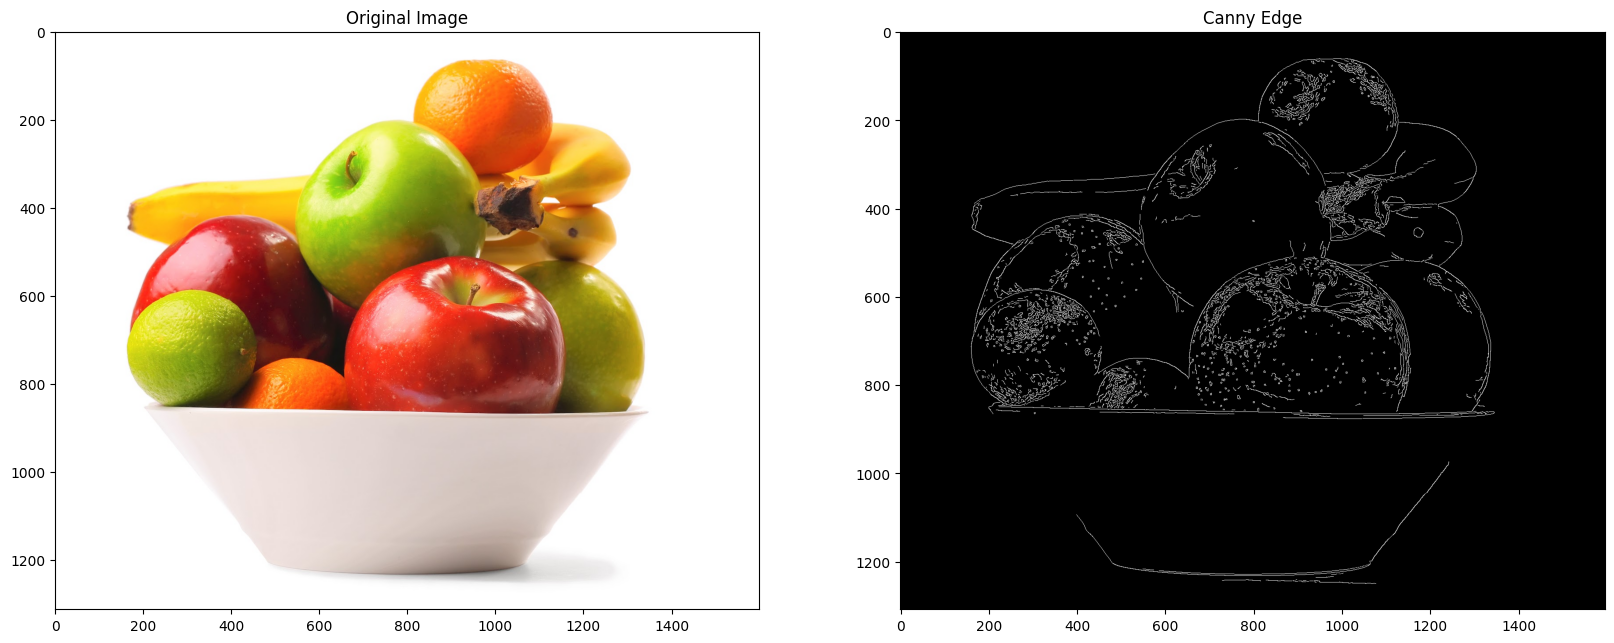

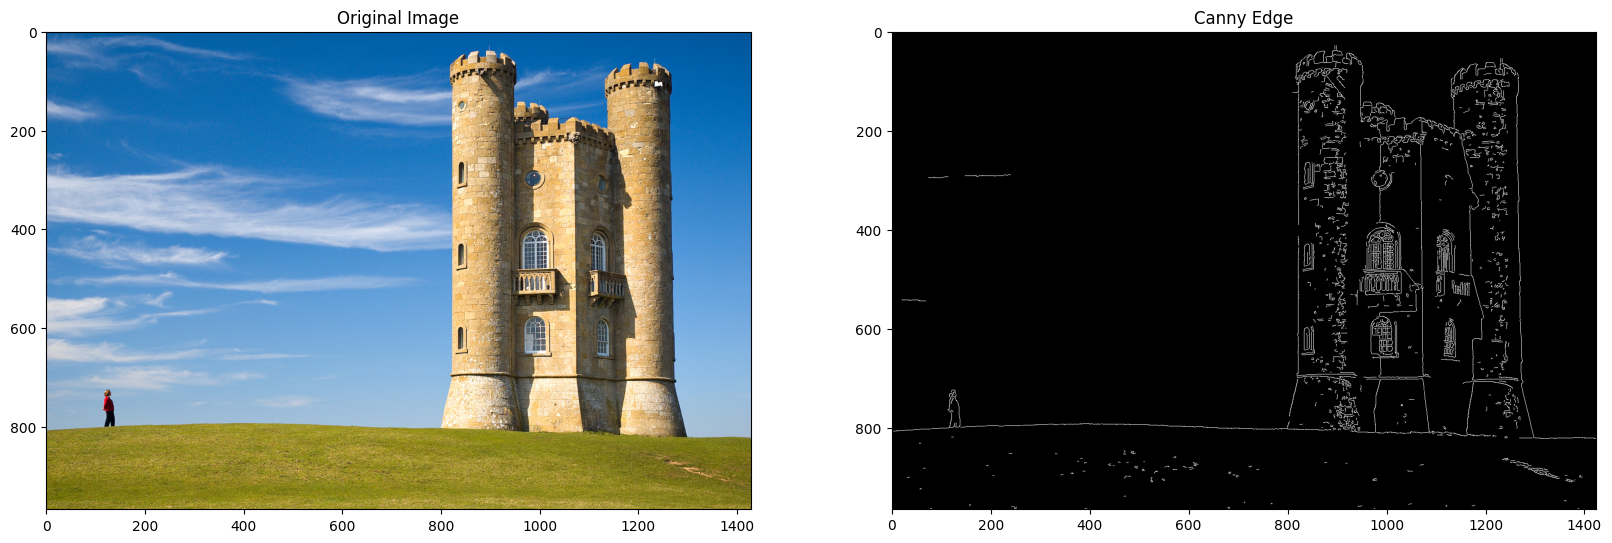

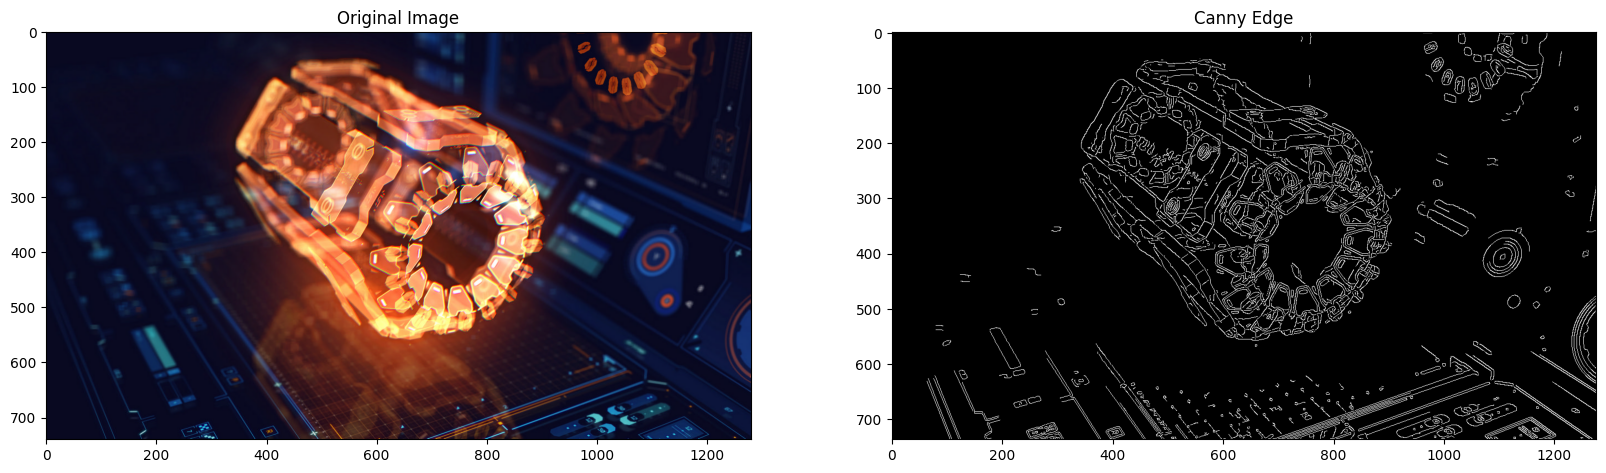

In [6]:
fruitConfig = {
    "sigma": 1.75,
    "lowThreshold": 0.0104,
    "highThreshold": 0.0154
}
fvConfig = {
    "sigma": 1.75,
    "lowThreshold": 0.0314,
    "highThreshold": 0.0474
}
coreConfig = {
    "sigma": 1.75,
    "lowThreshold": 0.0114,
    "highThreshold": 0.0194
}
images = ["Media/bowl-of-fruit.jpg","Media/castle.jpg","Media/core.jpg"]
configs = [fruitConfig,fvConfig,coreConfig]
for i in range(len(images)):
    config = configs[i]
    img = imageRead(images[i])
    tensor = img2tensor(img)

    plt.figure(figsize=(20,20))
    plt.subplot(1,2,1)
    plt.title("Original Image")
    plt.imshow(img, cmap='gray')
    plt.subplot(1,2,2)
    plt.title("Canny Edge")
    plt.imshow(tensor2img(MyCannyFull(tensor,config["sigma"],config["lowThreshold"],config["highThreshold"])), cmap='gray')

In [7]:
"""
Old iterations of functions
 """
'''
def angleRounder(angle):
    # Angle comes in radians
    degrees = torch.rad2deg(angle)
    if(degrees<0):
        degrees+=180
    degrees%= 180
    if((degrees>=0 and degrees<22.5) or (degrees>=157.5 and degrees<=180)):
        return 1,0        
    elif(degrees>=22.5 and degrees<67.5):
        return 1,1
    elif(degrees>=67.5 and degrees<112.5):
        return 0,1
    elif (degrees>=112.5 and degrees<157.5):
        return -1,1
    print(degrees)

# print("i: ",i,",j: ",j,", k: ",k,", val: ",intensityImg[0][0][i+(xDir*k)][j+(yDir*k)])
def nonMaxSupression(intensityImg, gradImg,supressionDistance):    
    """
    This function takes two B,C,H,W images (expects them to be this format, no other will work), and applies non-max suppression on them.
    """
    supressedImg = torch.zeros(intensityImg.shape)
    print(supressedImg.shape)
    for i in range(supressionDistance,supressedImg.shape[2]-supressionDistance):
        for j in range(supressionDistance,supressedImg.shape[3]-supressionDistance):
            xDir,yDir = angleRounder(gradImg[0][0][i][j])
            maxIntensity = -math.inf
            maxK = -math.inf
            for k in range(-supressionDistance,supressionDistance+1):
                if(intensityImg[0][0][i+(xDir*k)][j+(yDir*k)]>maxIntensity):
                    # This is just k'th neighbor in gradient's direction, k= (-SupDist,SupDist)
                    maxIntensity=intensityImg[0][0][i+(xDir*k)][j+(yDir*k)]
                    maxK = k
            for k in range(-supressionDistance,supressionDistance+1):
                if(k != maxK):
                    supressedImg[0][0][i+(xDir*k)][j+(yDir*k)]=0
                else:
                    supressedImg[0][0][i+(xDir*k)][j+(yDir*k)]=intensityImg[0][0][i+(xDir*k)][j+(yDir*k)]            
    return supressedImg

def eff_nonMaxSupression(intensityImg, gradImg, supressionDistance):
    supressedImg = torch.zeros_like(intensityImg)
    
    # Pre-compute rounded angles for the entire gradient image
    rounded_angles = eff_angleRounder(gradImg)
    xDir, yDir = rounded_angles[0, 0, :, :], rounded_angles[0, 1, :, :]
    
    for i in range(supressionDistance, supressedImg.shape[2] - supressionDistance):
        for j in range(supressionDistance, supressedImg.shape[3] - supressionDistance):
            x, y = xDir[i, j].item(), yDir[i, j].item()
            x_neigh = torch.tensor([i + (x * k) for k in range(-supressionDistance, supressionDistance + 1)])
            y_neigh = torch.tensor([j + (y * k) for k in range(-supressionDistance, supressionDistance + 1)])
            intensities = intensityImg[0, 0, x_neigh, y_neigh]
            max_intensity, max_idx = torch.max(intensities, dim=0)
            mask = torch.ones_like(intensities, dtype=torch.bool)
            mask[max_idx] = 0
            supressedImg[0, 0, x_neigh[mask], y_neigh[mask]] = 0
            supressedImg[0, 0, x_neigh[max_idx], y_neigh[max_idx]] = max_intensity
    return supressedImg

def eff_angleRounder(gradImg):
    angles = torch.atan2(gradImg[0, 1, :, :], gradImg[0, 0, :, :])
    degrees = torch.rad2deg(angles)
    degrees[degrees < 0] += 180
    rounded_angles = torch.zeros_like(gradImg, dtype=torch.int)

    mask1 = (degrees >= 0) & (degrees < 22.5) | (degrees >= 157.5) & (degrees <= 180)
    mask2 = (degrees >= 22.5) & (degrees < 67.5)
    mask3 = (degrees >= 67.5) & (degrees < 112.5)
    mask4 = (degrees >= 112.5) & (degrees < 157.5)

    rounded_angles[0, 0, mask1] = 1
    rounded_angles[0, 1, mask1] = 0
    rounded_angles[0, 0, mask2] = 1
    rounded_angles[0, 1, mask2] = 1
    rounded_angles[0, 0, mask3] = 0
    rounded_angles[0, 1, mask3] = 1
    rounded_angles[0, 0, mask4] = -1
    rounded_angles[0, 1, mask4] = 1

    return rounded_angles

    
def MyCannyFullOld(img,sigma,lowThreshold,highThreshold,test=0):
    nmsImage = MyCanny(img,sigma,-1)
    discovered = torch.zeros_like(img)
    definitePoints = thresholder(nmsImage,highThreshold)
    definiteCoOrds = torch.nonzero(definitePoints)
    bfsQueue = [tuple(coord) for coord in definiteCoOrds]    
    
    while(len(bfsQueue)>0):        
        pixel = bfsQueue.pop()
        x = pixel[2]
        y = pixel[3]
        if x > 0 and x < img.shape[2] - 1 and y > 0 and y < img.shape[3] - 1:
            discovered[0,0,x,y]=1
            neighbors = nmsImage[0,0,x-1:x+2,y-1:y+2]
            undiscoveredMask = (discovered[0, 0, x-1:x+2, y-1:y+2] == 0)
            thresholdMask = neighbors > lowThreshold
            print("x:",x,", y: ",y,", ",thresholdMask.shape)
            update_mask = torch.logical_and(thresholdMask, undiscoveredMask)
            if(test==0):            
                discovered[0, 0, x-1:x+2, y-1:y+2] = torch.where(update_mask, 1, discovered[0, 0, x-1:x+2, y-1:y+2])
    return discovered>0
'''

'\ndef angleRounder(angle):\n    # Angle comes in radians\n    degrees = torch.rad2deg(angle)\n    if(degrees<0):\n        degrees+=180\n    degrees%= 180\n    if((degrees>=0 and degrees<22.5) or (degrees>=157.5 and degrees<=180)):\n        return 1,0        \n    elif(degrees>=22.5 and degrees<67.5):\n        return 1,1\n    elif(degrees>=67.5 and degrees<112.5):\n        return 0,1\n    elif (degrees>=112.5 and degrees<157.5):\n        return -1,1\n    print(degrees)\n\n# print("i: ",i,",j: ",j,", k: ",k,", val: ",intensityImg[0][0][i+(xDir*k)][j+(yDir*k)])\ndef nonMaxSupression(intensityImg, gradImg,supressionDistance):    \n    """\n    This function takes two B,C,H,W images (expects them to be this format, no other will work), and applies non-max suppression on them.\n    """\n    supressedImg = torch.zeros(intensityImg.shape)\n    print(supressedImg.shape)\n    for i in range(supressionDistance,supressedImg.shape[2]-supressionDistance):\n        for j in range(supressionDistance,